<a href="https://colab.research.google.com/github/Ouyu-Han/Time-Series-Forecasting/blob/main/Back_test_ETS_and_ARIMA_time_series_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U scikit-learn pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


## Read in the approriate packages

In [ ]:
from pandas_datareader import data as pdr #read data from yahoo finance api
import matplotlib.pyplot as plt #viz #GUI manager
import seaborn as sns #viz #plotly is another package
import datetime
import pandas as pd
import numpy as np
from pandas import Grouper #groupby
#statistical data exploration, conducting statistical tests, and estimation of different statistical models
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf #autocorrelation plot
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # double and triple exponential smoothing
from pandas.plotting import autocorrelation_plot #autocorrelation plot
from statsmodels.graphics.gofplots import qqplot #residual diagnostics
from sklearn.metrics import mean_squared_error #accuracy metrics
from math import sqrt
from sklearn.metrics import mean_absolute_error #accuracy metrics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from random import gauss #create gaussian white noise
from random import seed
from pandas import Series
from statsmodels.tsa.stattools import adfuller # Augmented Dickey Fuller test for testing stationarity

from statsmodels.tsa.arima_model import ARIMA #for manual ARIMA
import pmdarima as pm #auto arima

## Read in the monthly anti-diabetic drug sales in Australia dataset

## Stationarity

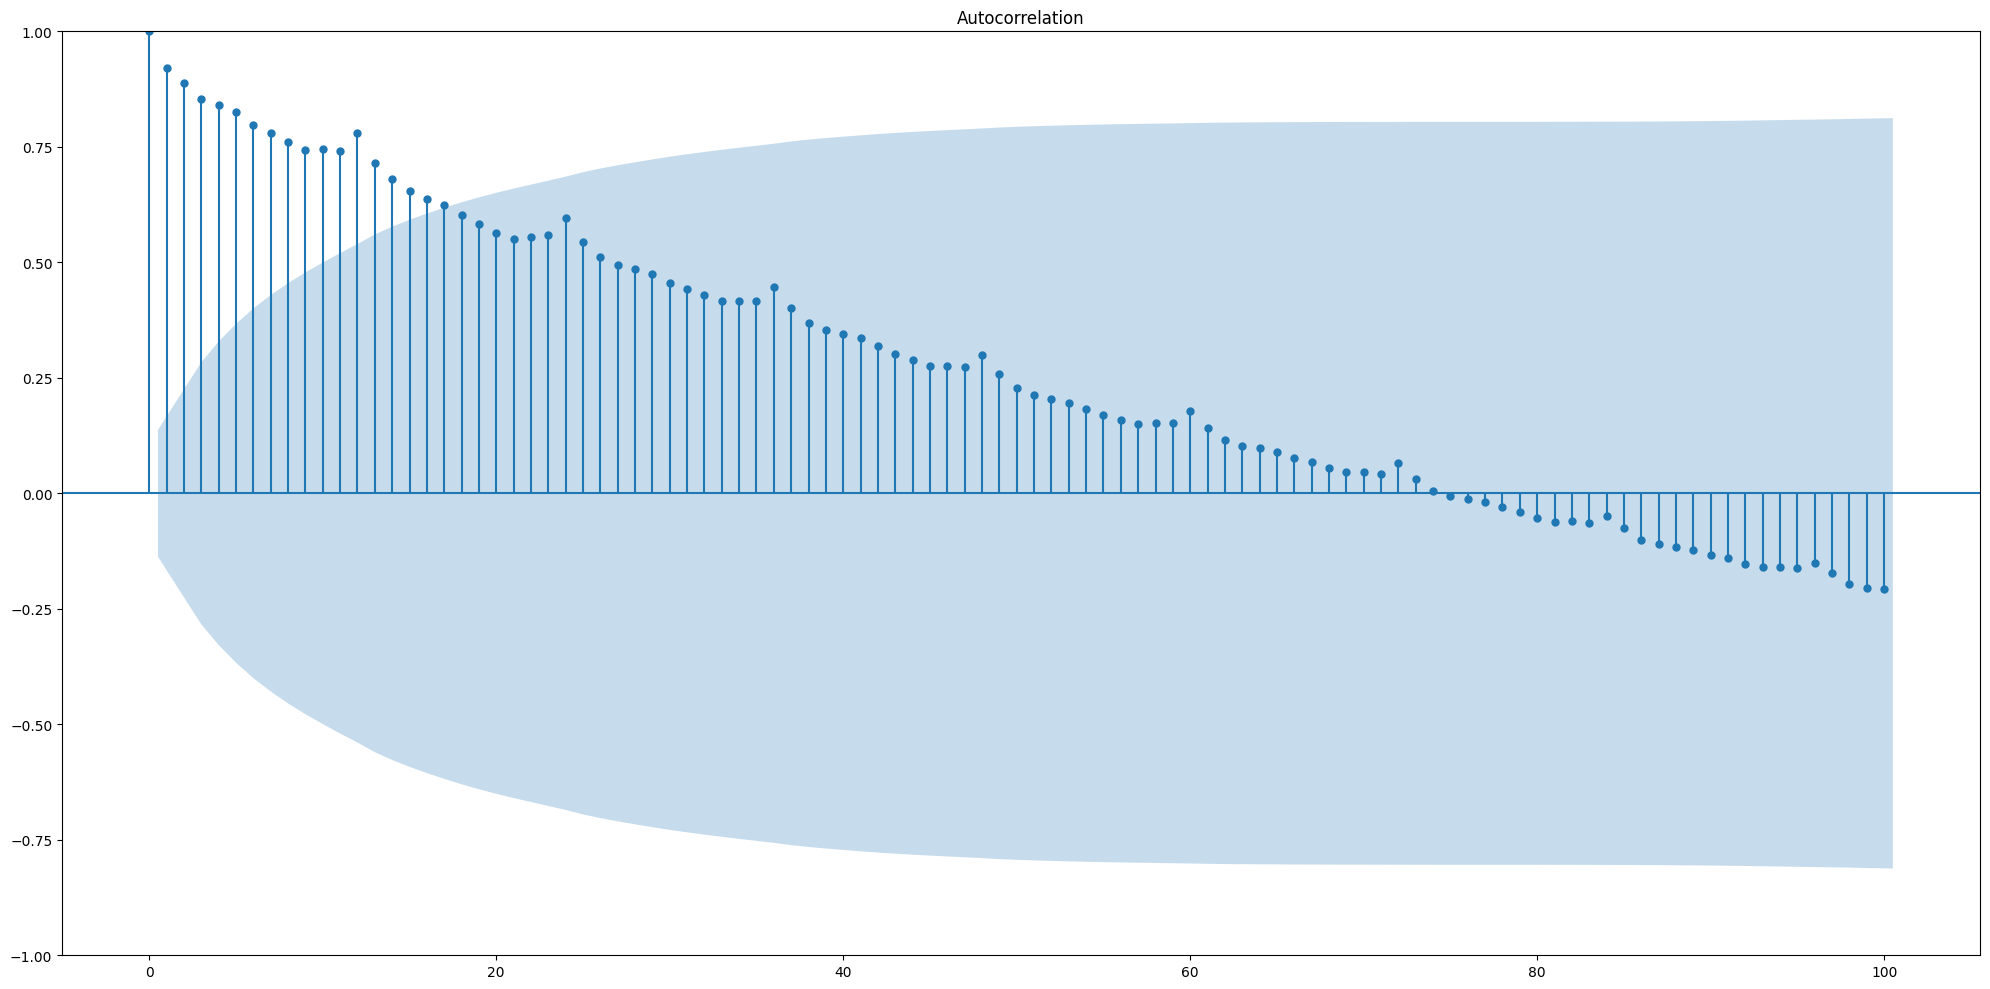

In [ ]:
#check if the data is stationary

# autocorrelation plot of the dataset
fig = plot_acf(drug_sales_df, lags=100)
fig.set_size_inches((20, 10))
# Tight layout to realign things
fig.tight_layout()
plt.show()

data has trend as well as seasonlity of 12 months

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drug_sales_df = pd.read_csv('/content/drive/MyDrive/Time Series Forecasting/drug_sales_australia.csv',
                            parse_dates=['date'],
                            index_col=['date'])
drug_sales_df

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869
...,...
2008-02-01,21.654285
2008-03-01,18.264945
2008-04-01,23.107677


## Differencing

<Axes: xlabel='date'>

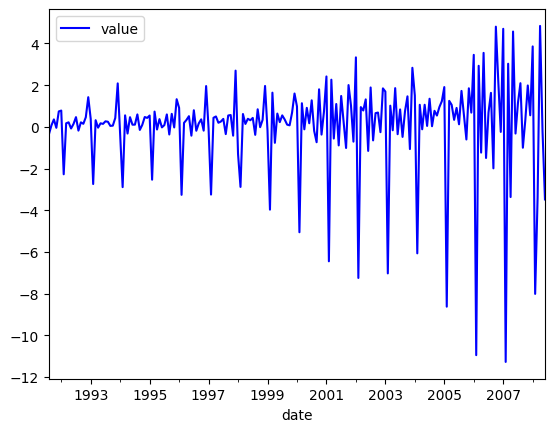

In [ ]:
#create differenced dataset
first_diff_df = drug_sales_df.diff().dropna()
first_diff_df.plot(color='blue')

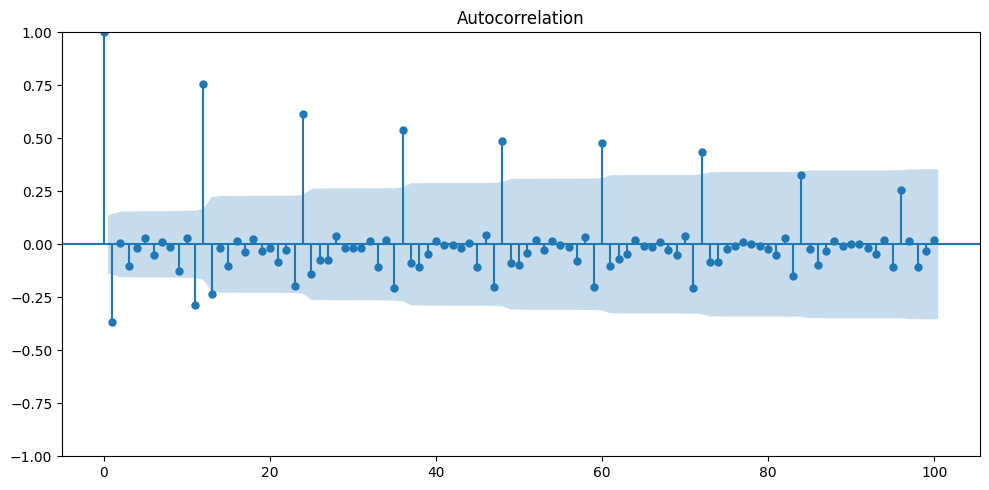

In [ ]:
# autocorrelation plot of differenced dataset
fig = plot_acf(first_diff_df, lags=100)
fig.set_size_inches((10, 5))
# Tight layout to realign things
fig.tight_layout()
plt.show()

In [ ]:
X = first_diff_df.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.495172
p-value: 0.116653
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575


From the ACF and line plot and the ADF test p-value we can deduce that the series is non-stationary. As we can see a seasonal pattern, let us apply seasonal differencing.

<Axes: xlabel='date'>

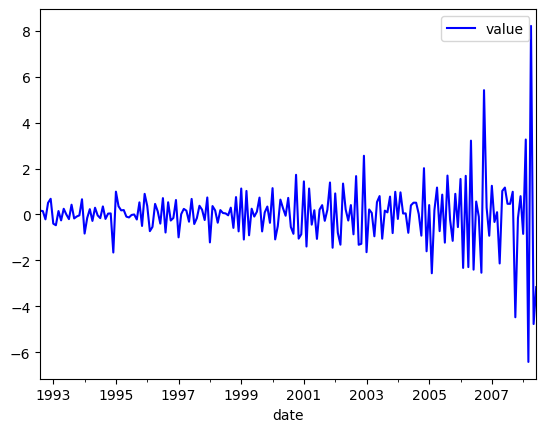

In [ ]:
seasonal_diff_df = first_diff_df.diff(12).dropna()
seasonal_diff_df.plot(color = 'blue')

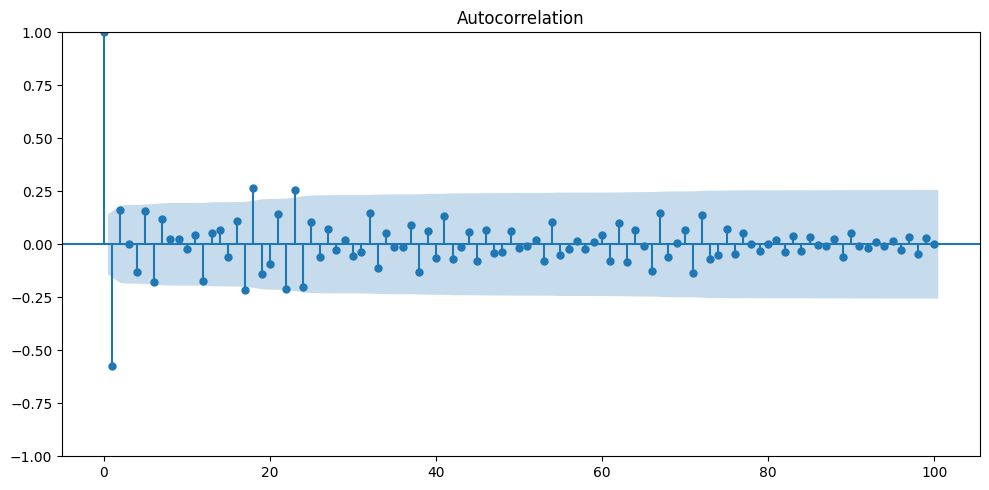

In [ ]:
# autocorrelation plot of the seasonaly differenced dataset
fig = plot_acf(seasonal_diff_df, lags=100)
fig.set_size_inches((10, 5))
# Tight layout to realign things
fig.tight_layout()
plt.show()

In [ ]:
X = seasonal_diff_df.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.783440
p-value: 0.000058
Critical Values:
	1%: -3.468
	5%: -2.878
	10%: -2.576


Since p-value is less than 0.05 we can reject the null hypothesis and the data is stationary.

In [ ]:
backtest_periods = [
    ('2004-07-01', '2005-06-30'),
    ('2005-07-01', '2006-06-30'),
    ('2006-07-01', '2007-06-30'),
    ('2007-07-01', '2008-06-30')
]


In [ ]:
splits = []

for start, end in backtest_periods:
    test_data = drug_sales_df.loc[start:end]
    train_data = drug_sales_df.loc[:pd.to_datetime(start) - pd.offsets.MonthEnd(1)]

    splits.append((train_data, test_data))

    print(
        f"Train end: {train_data.index[-1].date()}, "
        f"Test start: {test_data.index[0].date()}, "
        f"Test size: {len(test_data)}"
    )


Train end: 2004-06-01, Test start: 2004-07-01, Test size: 12
Train end: 2005-06-01, Test start: 2005-07-01, Test size: 12
Train end: 2006-06-01, Test start: 2006-07-01, Test size: 12
Train end: 2007-06-01, Test start: 2007-07-01, Test size: 12


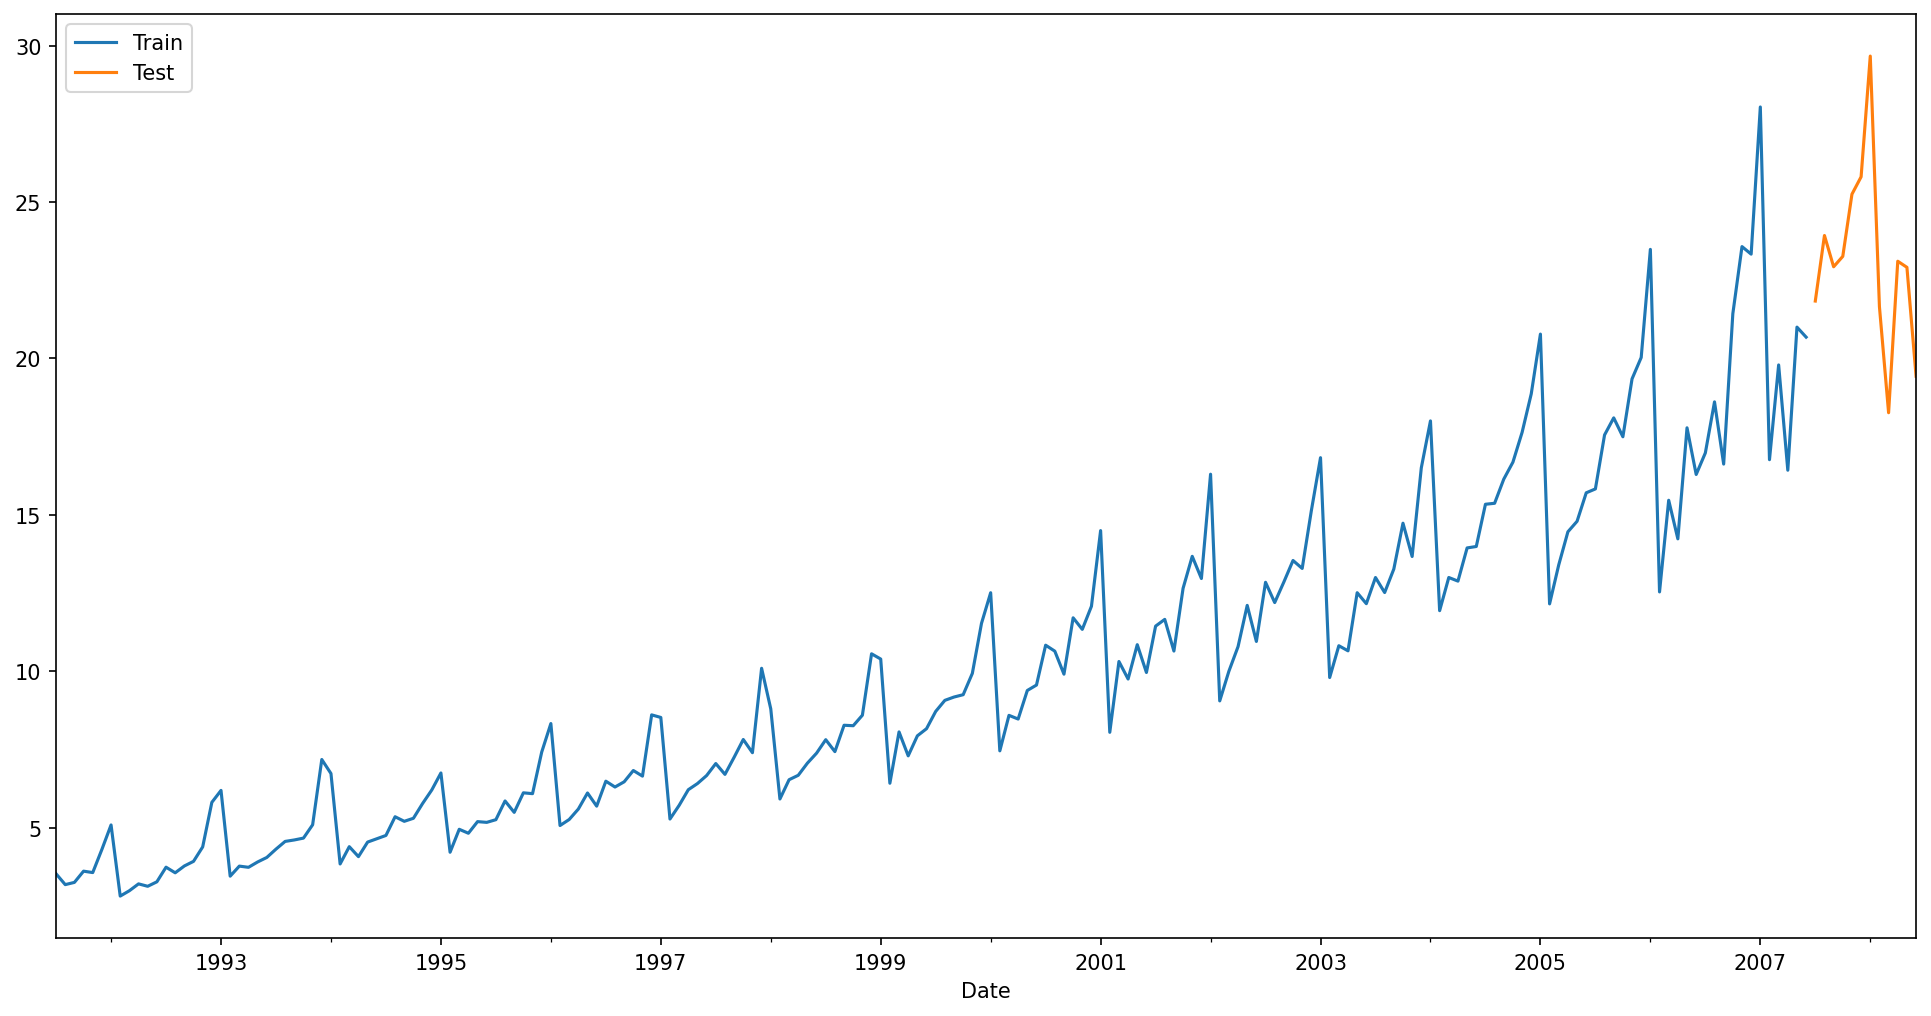

In [ ]:
#Plot train and test data

# to set the plot size
plt.figure(figsize=(16, 8), dpi=150)

# using plot method to plot close prices.
# in plot method we set the label and color of the curve.
train_data['value'].plot(label='Train')
test_data['value'].plot(label='Test')

# adding Label to the x-axis
plt.xlabel('Date')

# adding legend to the curve
plt.legend()

## Mannual ARIMA Function

In [ ]:
def fit_manual_arima(train, steps=12, order=(2,1,1), alpha=0.05):

    model = sm.tsa.ARIMA(train, order=order)
    fit = model.fit()

    # point forecast
    forecast = fit.forecast(steps=steps)

    # standard errors
    pred = fit.get_prediction(
        start=len(train),
        end=len(train) + steps - 1
    )
    stderr = pred.se_mean

    z = 1.96  # 95% CI
    lower = forecast - z * stderr
    upper = forecast + z * stderr

    return {
        "forecast": pd.Series(forecast),
        "lower_ci": pd.Series(lower),
        "upper_ci": pd.Series(upper),
        "summary": fit.summary()
    }

## Auto ARIMA - Non Seasonal Function

In [ ]:
def fit_auto_arima_nonseasonal(
    train,
    steps=12,
    start_p=0,
    start_q=0,
    max_p=3,
    max_q=3,
    alpha=0.05
):

    model = pm.auto_arima(
        train,
        start_p=start_p,
        start_q=start_q,
        test="adf",
        max_p=max_p,
        max_q=max_q,
        d=None,
        seasonal=False,
        m=12,
        trace=True,
        error_action="ignore",
        suppress_warnings=True,
        stepwise=True
    )

    forecast, confint = model.predict(
        n_periods=steps,
        return_conf_int=True,
        alpha=alpha
    )

    return {
        "forecast": pd.Series(forecast),
        "lower_ci": pd.Series(confint[:, 0]),
        "upper_ci": pd.Series(confint[:, 1]),
        "summary": model.summary()
    }


## Auto ARIMA - Seasonal

In [ ]:
def fit_auto_arima_seasonal(
    train,
    steps=12,
    start_p=1,
    start_q=1,
    max_p=3,
    max_q=3,
    D=1,
    m=12,
    alpha=0.05
):

    model = pm.auto_arima(
        train,
        start_p=start_p,
        start_q=start_q,
        test="adf",
        max_p=max_p,
        max_q=max_q,
        d=None,
        D=D,
        seasonal=True,
        m=m,
        start_P=0,
        trace=True,
        error_action="ignore",
        suppress_warnings=True,
        stepwise=True
    )

    forecast, confint = model.predict(n_periods=steps, return_conf_int=True, alpha=alpha)

    return {
        "forecast": pd.Series(forecast),
        "lower_ci": pd.Series(confint[:, 0]),
        "upper_ci": pd.Series(confint[:, 1]),
        "summary": model.summary()
    }


## Simple Exponential Smoothing

In [ ]:
def simple_exp_smoothing_models(
    train_series,
    forecast_steps=12,
    alphas=(0.2, 0.5),
    plot=True
):
    results = {}

    # fixed alphas
    for alpha in alphas:
        model = SimpleExpSmoothing(train_series).fit(
            smoothing_level=alpha,
            optimized=False
        )
        results[f"alpha_{alpha}"] = {
            "model": model,
            "forecast": model.forecast(forecast_steps)
        }

    # optimized alpha
    opt_model = SimpleExpSmoothing(train_series).fit()
    opt_alpha = opt_model.model.params['smoothing_level']

    results["alpha_optimized"] = {
        "model": opt_model,
        "forecast": opt_model.forecast(forecast_steps),
        "alpha": opt_alpha
    }

    if plot:
        ax = train_series.plot(figsize=(16,6), color="black", label="Observed")

        for key, res in results.items():
            res["forecast"].plot(ax=ax, legend=True)

        plt.legend()
        plt.show()

    return results


## Double Exponential Smoothing

In [ ]:
def double_exponential_smoothing(
    train_series,
    forecast_steps=12,
    include_add=True,
    include_mul=True,
    plot=True,
    title="Double Exponential Smoothing (Holt)"
):
    results = {}

    if include_add:
        ets_add = ExponentialSmoothing(
            train_series,
            trend='add'
        ).fit()
        results["additive"] = {
            "model": ets_add,
            "forecast": ets_add.forecast(forecast_steps),
            "fitted": ets_add.fittedvalues
        }

    if include_mul:
        ets_mul = ExponentialSmoothing(
            train_series,
            trend='mul'
        ).fit()
        results["multiplicative"] = {
            "model": ets_mul,
            "forecast": ets_mul.forecast(forecast_steps),
            "fitted": ets_mul.fittedvalues
        }

    if plot:
        ax = train_series.plot(
            marker='o',
            color='black',
            figsize=(16,6),
            legend=True,
            label='Train'
        )

        for name, res in results.items():
            res["forecast"].plot(
                ax=ax,
                marker='o',
                legend=True,
                label=f'Double ETS {name}'
            )
            res["fitted"].plot(
                ax=ax,
                linestyle='--'
            )

        plt.title(title)
        plt.show()

    return results


## Triple Exponential Smoothing

In [ ]:
def triple_exponential_smoothing(
    train_series,
    forecast_steps=12,
    seasonal_periods=12,
    include_add=True,
    include_mul=True,
    plot=True,
    title="Triple Exponential Smoothing (Holt-Winters)"
):
    results = {}

    if include_add:
        ets_add = ExponentialSmoothing(
            train_series,
            trend='add',
            seasonal='add',
            seasonal_periods=seasonal_periods
        ).fit()
        results["additive"] = {
            "model": ets_add,
            "forecast": ets_add.forecast(forecast_steps),
            "fitted": ets_add.fittedvalues
        }

    if include_mul:
        ets_mul = ExponentialSmoothing(
            train_series,
            trend='mul',
            seasonal='mul',
            seasonal_periods=seasonal_periods
        ).fit()
        results["multiplicative"] = {
            "model": ets_mul,
            "forecast": ets_mul.forecast(forecast_steps),
            "fitted": ets_mul.fittedvalues
        }

    if plot:
        ax = train_series.plot(
            marker='o',
            color='black',
            figsize=(16,6),
            legend=True,
            label='Train'
        )

        for name, res in results.items():
            res["forecast"].plot(
                ax=ax,
                marker='o',
                legend=True,
                label=f'Triple ETS {name}'
            )
            res["fitted"].plot(
                ax=ax,
                linestyle='--'
            )

        plt.title(title)
        plt.show()

    return results


## 4 period backtesting

In [ ]:
periods = [
    (pd.Timestamp('2004-07-01'), pd.Timestamp('2005-06-30')),
    (pd.Timestamp('2005-07-01'), pd.Timestamp('2006-06-30')),
    (pd.Timestamp('2006-07-01'), pd.Timestamp('2007-06-30')),
    (pd.Timestamp('2007-07-01'), pd.Timestamp('2008-06-30')),
]


In [ ]:
h = 12  # forecast horizon
all_results = []

for i, (start, end) in enumerate(periods, 1):

    print(f"Running period {i}: {start.date()} to {end.date()}")

    train_data = drug_sales_df.loc[:start - pd.offsets.MonthEnd(1)]
    test_data  = drug_sales_df.loc[start:end]

    # ===== manual ARIMA =====
    arima_res = fit_manual_arima(train_data, steps=h, order=(2,1,1))
    arima_fc = arima_res["forecast"]
    arima_fc.index = test_data.index

    # ===== auto ARIMA non-seasonal =====
    auto_ns_res = fit_auto_arima_nonseasonal(train_data, steps=h)
    auto_ns_fc = auto_ns_res["forecast"]
    auto_ns_fc.index = test_data.index

    # ===== auto ARIMA seasonal =====
    auto_s_res = fit_auto_arima_seasonal(train_data, steps=h)
    auto_s_fc = auto_s_res["forecast"]
    auto_s_fc.index = test_data.index

    # ===== simple exponential smoothing =====
    ses_res = simple_exp_smoothing_models(
        train_series=train_data,
        forecast_steps=h,
        plot=False
    )

    ses_fc_02  = ses_res["alpha_0.2"]["forecast"]
    ses_fc_05  = ses_res["alpha_0.5"]["forecast"]
    ses_fc_opt = ses_res["alpha_optimized"]["forecast"]

    ses_fc_02.index  = test_data.index
    ses_fc_05.index  = test_data.index
    ses_fc_opt.index = test_data.index

    # ===== double exponential smoothing =====
    des_res = double_exponential_smoothing(
        train_series=train_data,
        forecast_steps=h,
        plot=False
    )

    des_add_fc = des_res["additive"]["forecast"]
    des_mul_fc = des_res["multiplicative"]["forecast"]

    des_add_fc.index = test_data.index
    des_mul_fc.index = test_data.index

    # ===== triple exponential smoothing =====
    tes_res = triple_exponential_smoothing(
        train_series=train_data,
        forecast_steps=h,
        seasonal_periods=12,
        plot=False
    )

    tes_add_fc = tes_res["additive"]["forecast"]
    tes_mul_fc = tes_res["multiplicative"]["forecast"]

    tes_add_fc.index = test_data.index
    tes_mul_fc.index = test_data.index

    # ===== store results =====
    all_results.append({
        "period": f"P{i}",
        "start": start,
        "end": end,
        "dates": test_data.index,
        "actual": test_data.values,

        "ARIMA_manual": arima_fc.values,
        "Auto_ARIMA_NS": auto_ns_fc.values,
        "Auto_ARIMA_S": auto_s_fc.values,

        "SES_0.2": ses_fc_02.values,
        "SES_0.5": ses_fc_05.values,
        "SES_opt": ses_fc_opt.values,

        "DES_add": des_add_fc.values,
        "DES_mul": des_mul_fc.values,

        "TES_add": tes_add_fc.values,
        "TES_mul": tes_mul_fc.values
    })


Running period 1: 2004-07-01 to 2005-06-30


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1123.692, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=598.075, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=961.453, Time=0.34 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.65 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=565.571, Time=0.81 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=558.166, Time=1.29 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=560.084, Time=2.49 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=566.735, Time=2.32 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=558.602, Time=3.21 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=1.18 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=578.474, Time=2.92 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=558.613, Time=1.72 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 17.151 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=226.709, Time=1.14 s

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

Running period 2: 2005-07-01 to 2006-06-30
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1235.924, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=663.903, Time=0.05 sec


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1060.107, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=633.748, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=624.012, Time=0.24 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=625.917, Time=0.26 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=634.244, Time=0.36 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=624.754, Time=0.19 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=643.455, Time=0.65 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=624.552, Time=0.30 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 2.480 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=277.978, Time=1.31 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=328.707, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=307.343, Time=1.34 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : 

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

Running period 3: 2006-07-01 to 2007-06-30
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1350.798, Time=0.03 sec


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

 ARIMA(1,0,0)(0,0,0)[0]             : AIC=750.098, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1165.103, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=711.946, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=703.384, Time=0.21 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=705.294, Time=0.34 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=710.434, Time=0.32 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=705.089, Time=0.20 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=695.975, Time=0.41 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=695.558, Time=0.63 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=695.085, Time=0.40 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=704.127, Time=0.23 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=698.897, Time=0.64 sec

Best model:  ARIMA(2,0,3)(0,0,0)[0]          
Total fit time: 3.921 seconds
Performing stepwise 

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

Running period 4: 2007-07-01 to 2008-06-30
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1473.879, Time=0.02 sec


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

 ARIMA(1,0,0)(0,0,0)[0]             : AIC=844.283, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1279.130, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=802.660, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=794.855, Time=0.21 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=795.190, Time=0.38 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=799.333, Time=0.34 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=797.769, Time=0.15 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=785.896, Time=0.51 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=792.088, Time=1.51 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=788.158, Time=2.11 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=788.802, Time=1.56 sec

Best model:  ARIMA(3,0,2)(0,0,0)[0]          
Total fit time: 7.281 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

## Model Evaluation


In [ ]:
def calculate_metrics(
    actuals,
    predictions,
    model_name,
    period_name
):
    actuals = np.asarray(actuals).flatten()
    predictions = np.asarray(predictions).flatten()

    rmse = sqrt(mean_squared_error(actuals, predictions))
    mae = mean_absolute_error(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

    return {
        "Period": period_name,
        "Model": model_name,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape
    }


In [ ]:
metrics_results = []


for start, end in periods:
    period_name = f"{start.strftime('%Y-%m')}–{end.strftime('%Y-%m')}"


    model_forecasts = {
        "Manual ARIMA": arima_fc,
        "Auto ARIMA (Non-seasonal)": auto_ns_fc,
        "Auto ARIMA (Seasonal)": auto_s_fc,
        "SES (alpha=0.2)": ses_fc_02,
        "SES (alpha=0.5)": ses_fc_05,
        "SES (optimized)": ses_fc_opt,
        "Double ETS (add)": des_add_fc,
        "Double ETS (mul)": des_mul_fc,
        "Triple ETS (add)": tes_add_fc,
        "Triple ETS (mul)": tes_mul_fc
    }


    for model_name, fc in model_forecasts.items():
        metrics_results.append(
            calculate_metrics(
                test_data.values,
                fc.values,
                model_name,
                period_name
            )
        )


metrics_df = pd.DataFrame(metrics_results)
metrics_df


,Period,Model,RMSE,MAE,MAPE
0,2004-07–2005-06,Manual ARIMA,4.610302,4.165356,28.356136
1,2004-07–2005-06,Auto ARIMA (Non-seasonal),4.637676,4.095974,27.980573
2,2004-07–2005-06,Auto ARIMA (Seasonal),7.330084,7.144372,45.355037
3,2004-07–2005-06,SES (alpha=0.2),4.682516,4.229991,28.804871
4,2004-07–2005-06,SES (alpha=0.5),4.804691,4.345571,29.580429
5,2004-07–2005-06,SES (optimized),4.769028,4.311922,29.354636
6,2004-07–2005-06,Double ETS (add),5.823580,5.289431,35.904916
7,2004-07–2005-06,Double ETS (mul),6.594824,6.102521,41.137290
8,2004-07–2005-06,Triple ETS (add),7.506836,7.344988,46.455490
9,2004-07–2005-06,Triple ETS (mul),7.344834,7.237349,45.568190


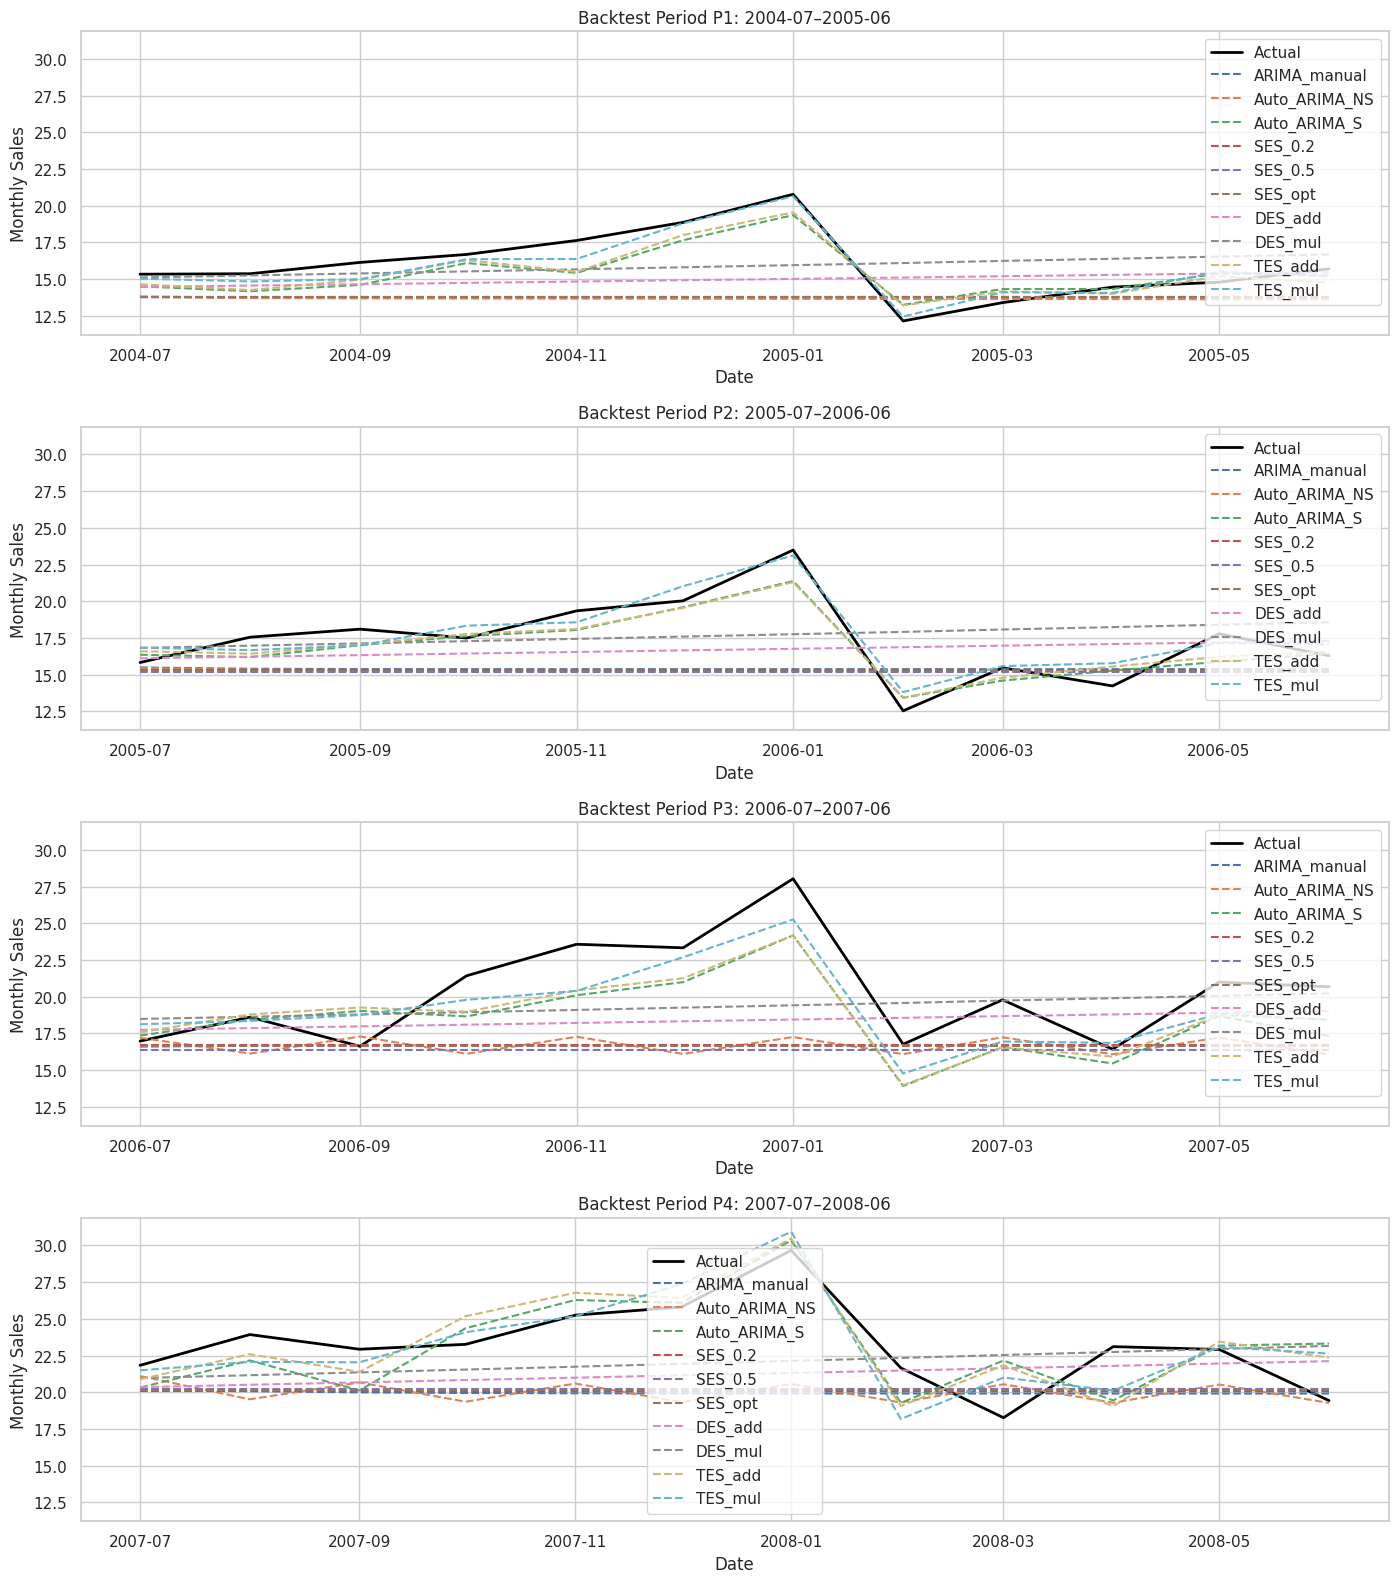

In [ ]:
fig, axes = plt.subplots(len(all_results), 1, figsize=(14, 4*len(all_results)), sharey=True)

for i, res in enumerate(all_results):
    ax = axes[i]
    ax.plot(res["dates"], res["actual"], label="Actual", color="black", linewidth=2)

    # plot all model forecasts
    for key, value in res.items():
        if key in ["period", "start", "end", "dates", "actual"]:
            continue
        ax.plot(res["dates"], value, linestyle="--", label=key)
        ax.legend()

    ax.set_title(f"Backtest Period {res['period']}: {res['start'].strftime('%Y-%m')}–{res['end'].strftime('%Y-%m')}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Monthly Sales")


plt.tight_layout()
plt.show()


Based on the backtesting results, I would use the Auto ARIMA (Non-seasonal) model to forecast the next 12 months. This model achieves the lowest overall prediction error, with RMSE ≈ 4.64, MAE ≈ 4.10, and MAPE ≈ 27.98%, outperforming both manual ARIMA and all ETS/SES variants. Its automatic parameter selection reduces the need for manual tuning, making it more efficient and robust for future forecasts. Moreover, the data shows no strong seasonal pattern, so a non-seasonal ARIMA is sufficient to capture the underlying trend accurately.